# Homework 3 - Group 10

In this notebook we will build and train a network to identify bacteria populations from their genome sequence. To do so, we will implement a Multi-layer Perceptron using keras and train it on the genomics data set provided by tensorflow.

In [1]:
# Importing tensorflow, the dataset and matplotlib for plotting our performance later
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt


We will use the following function later because the sequences are string tensors, we cannot simply call tf.one_hot(x,4) on the data. More on that later.

In [2]:
def onehotify(tensor):
    """Transforms a string tensor into a one hot tensor"""
    vocab = {"A": "1", "C": "2", "G": "3", "T": "0" }
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In the following cell we load the dataset and store it in variables. We want to seperate train data and test data because we want the network to perform well on data it has not seen before. That is why we use the split argument. Because we set 'as_supervised' to true, every entry of the dataset will be stored in tuples. The 'with_info' is not absolutly necessary here but since the data is rather complex to understand we want to give you some further information and therefore print it. For the sake of this homework we just used 100000 examples of the dataset to train the network and 1000 examples for testing it.

In [3]:
# Hyperparameters
train_num = 100000
test_num = 1000

# Import dataset and take 100000 elements for training and 1000 for testing
(train_data, test_data), info = tfds.load('genomics_ood', split = ['train', 'test'], as_supervised = True, with_info = True)
train_ds = train_data.take(train_num)
test_ds = test_data.take(test_num)


print(info)

tfds.core.DatasetInfo(
    name='genomics_ood',
    version=0.0.1,
    description='Bacteria identification based on genomic sequences holds the promise of early
detection of diseases, but requires a model that can output low confidence
predictions on out-of-distribution (OOD) genomic sequences from new bacteria
that were not present in the training data.

We introduce a genomics dataset for OOD detection that allows other researchers
to benchmark progress on this important problem. New bacterial classes are
gradually discovered over the years. Grouping classes by years is a natural way
to mimic the in-distribution and OOD examples.

The dataset contains genomic sequences sampled from 10 bacteria classes that
were discovered before the year 2011 as in-distribution classes, 60 bacteria
classes discovered between 2011-2016 as OOD for validation, and another 60
different bacteria classes discovered after 2016 as OOD for test, in total 130
bacteria classes. Note that training, validation, 

In [4]:
glimpse = train_data.take(1)
list(glimpse.as_numpy_iterator())

[(b'AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT',
  7)]

Here, we preprocess our dataset. To be able to use our data easily we need to transform every entry into a one-hot vector. We do this by applying map() onto the dataset and using a lambda function. A lamda functions is simply a different way of defining functions and are pretty handy here. 

In the end of your data pipeline you typically call Dataset.batch() which allows to divide your training data into 'bitesized' chunks, which will be processed in parallel. A nice blog post which illustrates why we need it and how to choose your batch size can be found [here](https://deeplizard.com/learn/video/U4WB9p6ODjM). For our example we went with 128 (run on an Intel i7-7700HQ and 16 GB of RAM). You might want to adjust this depending on your system.

Prefetching just allows you to do any preprocessing on your data (like the reshaping) in parallel with your actual training, and not always stop training to get your hands on more data iteratively.
We used the AUTOTUNE parameter to let tensorflow set the prefetch value dynamically at runtime. For more information on prefetching see [this guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [5]:
# Input Pipeline
batch_size = 128
prefetch_num = tf.data.experimental.AUTOTUNE

# Turn every element in training and testing into a one hot tensor
train_ds = train_ds.map(lambda sample, target : (onehotify(sample), tf.one_hot(target, depth=10)))
test_ds = test_ds.map(lambda sample, target : (onehotify(sample), tf.one_hot(target, depth=10)))

# Batch the data
train_ds = train_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Prefetch the data to improve graph flow
train_ds = train_ds.prefetch(prefetch_num)
test_ds = test_ds.prefetch(prefetch_num)

# Model

Now we need to define a simple fully connected feed forward neural network. Our network consists of two hidden layers, both containing 256 units with the sigmoid activation function. For our output layer we are using 10 neurons with the softmax activation function.

In [6]:
# Building the network
class MLP(tf.keras.models.Model):

    def __init__(self):
        """Definining the network"""
        super(MLP, self).__init__()
        # Define the hidden layers
        self.hidden_layer1 = tf.keras.layers.Dense(256, tf.keras.activations.sigmoid)
        self.hidden_layer2 = tf.keras.layers.Dense(256, tf.keras.activations.sigmoid)
        # Create an output layer
        self.output_layer = tf.keras.layers.Dense(10, tf.keras.activations.softmax)

    def call(self, inputs):
        """Sequentially process the input through the network"""
        hidden_layer1_output = self.hidden_layer1(inputs)
        hidden_layer2_output = self.hidden_layer2(hidden_layer1_output)
        return self.output_layer(hidden_layer2_output)

# Training

In the following we train our network for 10 epochs using a learning rate of 0.1. As a loss we use the categorical cross entropy (explained here: https://www.youtube.com/watch?v=gFL4cCBrD04&feature=emb_title). As an optimizer we use SGD. We start with defining functions for a training step and testing and continue with actually training the network (next cell).

In [7]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [8]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = MLP()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


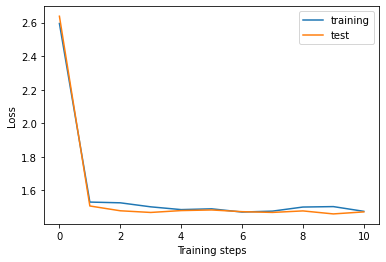

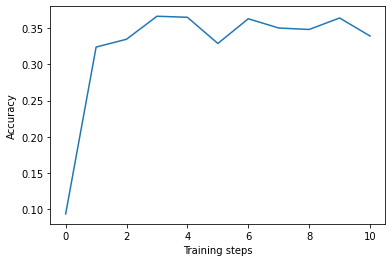

In [9]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

# Saving the model

Once we are happy with our model's performance we can export the learned weights, so we do not have to train the model everytime we want to use it.

In [10]:
model.save_weights("genomics_model.h5")

When we want to use our model in another instance, we can simply load the weights from our file.

In [11]:
new_model = model.load_weights("genomics_model.h5")